# Processing a run

In [27]:
import uproot
import numpy as np
#import pandas as pd
#import root_numpy as rootnp
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy import stats
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib
import scipy.ndimage
import glob
import awkward as ak
import sys
#from __future__ import division
import itertools


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')

In [31]:
import pylars
from pylars.plotting.plotwaveforms import plot_waveform

In [53]:
# Create processor
process = pylars.processing.simple_processor(sigma_level=5, baseline_samples=50)

In [55]:
#Load the raw data into the processor
data_path = '/disk/gfs_atp/xenoscope/SiPMs/char_campaign/raw_data/run6/room_temp_21072022/LED_ON_300K_51_0V/Module0/LED_ON_300K_51_0V_Module_0_0.root'
process.load_raw_data(data_path, 49,300)

In [41]:
process.set_tqdm(True, False)

In [7]:
'wf0' in process.raw_data.channels

True

In [8]:
channel_data = process.raw_data.get_channel_data('wf0')

In [10]:
channel_data

<Array [[15487, 15493, ... 15465, 15458]] type='20000 * 700 * int32'>

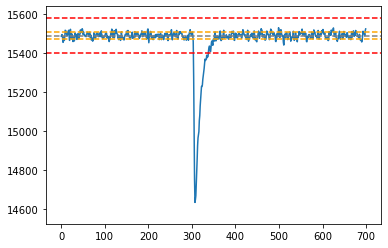

In [15]:
plot_waveform(channel_data[0])

### Hands(-)on functions

In [13]:
dz

In [14]:
baseline = waveform_processing.get_baseline_rough(channel_data[0], 50)
std = waveform_processing.get_std_rough(channel_data[0], 50)

In [16]:
pks = peak_processing.find_peaks_simple(np.array(channel_data[0]), baseline, std, 2)

In [28]:
_waveform = np.array(channel_data[0])

In [17]:
pks

[array([304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
        317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
        330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
        343, 344]),
 array([347, 348]),
 array([511])]

In [ ]:
process

In [21]:
areas, lengths, positions = waveform_processing.process_waveform(np.array(channel_data[0]), process.baseline_samples, process.sigma_level)

In [19]:
areas, lengths, positions

(array([130610.,    375.,      0.]), [41, 2, 1], [304, 347, 511])

### Full channel

In [56]:
resutls_ch0 = process.process_channel('wf0')

Processing channel wf0: 100%|██████████████████████████████████| 20000/20000 [00:02<00:00, 7267.78it/s]


In [40]:
%lprun -f process.process_channel -f waveform_processing.process_waveform -f peak_processing.find_peaks_simple -f pylars.processing.peaks._split_consecutive process.process_channel('wf0')

In [58]:
_waveform = np.array(channel_data[0])

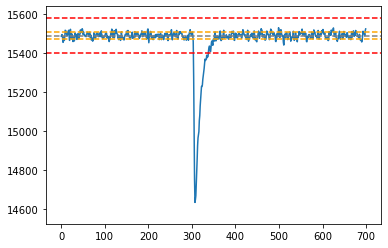

In [62]:
plot_waveform(_waveform)

In [45]:
import pandas as pd

In [59]:
results_ch0 = pd.DataFrame(resutls_ch0)

In [60]:
results_ch0

,channel,wf_number,peak_number,area,length,position
0,wf0,0,0,125405.0,34,304
1,wf0,1,0,127840.0,37,305
2,wf0,1,1,1360.0,3,347
3,wf0,2,0,125120.0,35,304
4,wf0,2,1,0.0,1,340
...,...,...,...,...,...,...
35917,wf0,19997,0,114155.0,26,306
35918,wf0,19998,0,124860.0,35,304
35919,wf0,19999,0,123345.0,30,305
35920,wf0,19999,1,2765.0,4,336


In [96]:
from pylars.plotting.plotprocessed import *

array([<AxesSubplot:xlabel='Area [integrated ADC counts]', ylabel='# events'>,
       <AxesSubplot:xlabel='Length [# samples]', ylabel='# events'>,
       <AxesSubplot:xlabel='Position [sample #]', ylabel='# events'>],
      dtype=object)

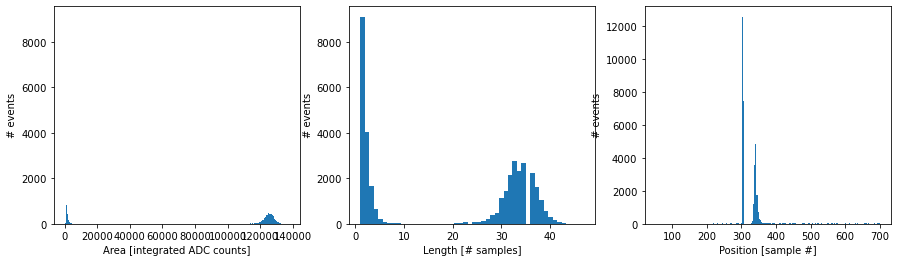

In [98]:
plot_3hists(results_ch0)

In [99]:
cut_mask = ((results_ch0['length'] > 20) &
            (results_ch0['position'] > 280) &
            (results_ch0['position'] < 400)
           )

array([<AxesSubplot:xlabel='Area [integrated ADC counts]', ylabel='# events'>,
       <AxesSubplot:xlabel='Length [# samples]', ylabel='# events'>,
       <AxesSubplot:xlabel='Position [sample #]', ylabel='# events'>],
      dtype=object)

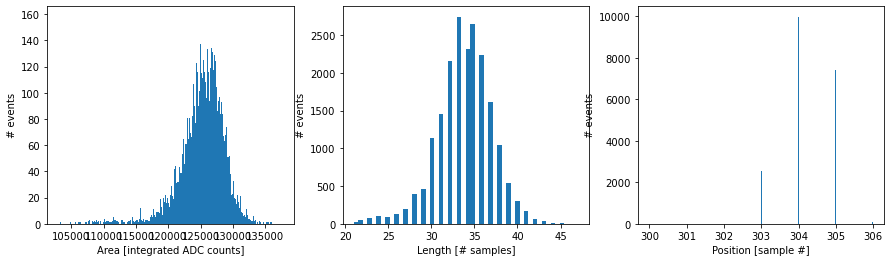

In [100]:
plot_3hists(results_ch0[cut_mask])